# **Homework 12 - Reinforcement Learning**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com



## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [ ]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d]==0.18.3 pyvirtualdisplay tqdm numpy==1.19.5 torch==1.8.1

接下來，設置好 virtual display，並引入所有必要的套件。

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm.notebook import tqdm

# 請不要更改 random seed !!!!
# 不然在judgeboi上 你的成績不會被reproduce !!!!

In [ ]:
seed = 543 # Do not change this
def fix(env, seed):
  env.seed(seed)
  env.action_space.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.set_deterministic(True)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

In [ ]:
%%capture
import gym
import random
import numpy as np
import math
import os
from collections import deque
from google.colab import drive
drive.mount('/content/drive')

env = gym.make('LunarLander-v2')

fix(env, seed)

In [ ]:
import time
start = time.time()

In [ ]:
!pip freeze

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [ ]:
print(env.observation_space)

`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [ ]:
print(env.action_space)

`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [ ]:
initial_state = env.reset()
print(initial_state)

接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [ ]:
random_action = env.action_space.sample()
print(random_action)

再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [ ]:
observation, reward, done, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [ ]:
print(done)

### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分
- 小艇每隻腳碰觸地面 +10 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.


In [ ]:
print(reward) # after doing a random action (0), the immediate reward is stored in this 

### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

2.2717430832380616
-1.880252524218463
-2.419177416825646
-1.541756929490872
-2.4384571603708296
-1.4366873191736136
3.2181820348632586
-1.8150127449745526
-1.7708848037169673
4.6488077257926195
-1.5304868312842064
-2.2778416068092597
-1.862866902715183
-2.4405314889779945
-2.460658333711335
3.6390918607870164
-2.2654263391114284
-2.2135589059606957
1.0226217535796536
-2.2281335385373495
-1.7494692006563628
2.721927282879517
-2.5402026527530936
-2.6801011465001907
-1.8292143955875406
1.2238518521831565
3.056283973873957
-1.5846288744594677
-1.298366034895223
-1.1949746767514842
-1.9848932340697434
-1.1095518480615556
-1.729827571547246
-0.8586992776184548
-1.5999853452418324
-0.8444193743054871
-1.6190323604119772
-0.8640436700749479
-0.4062052207619036
-1.2300141799054234
-0.32253749348529825
-0.23523222512315442
-0.8748817922862873
-0.9266315722266814
-1.2031411795698819
-0.2990749237483772
-0.4964414717130978
1.6237773854146667
4.96193731965401
-0.06250550714619749
2.0741620233478786

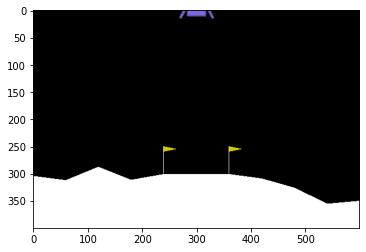

In [14]:

env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    print(reward)
    #img.set_data(env.render(mode='rgb_array'))
    #display.display(plt.gcf())
    #display.clear_output(wait=True)


## Policy Gradient

現在來搭建一個簡單的 policy network。
我們預設模型的輸入是 8-dim 的 observation，輸出則是離散的四個動作之一：

In [15]:
class PolicyGradientNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 4)

    def forward(self, state):
        hid = torch.relu(self.fc1(state))
        hid = torch.relu(self.fc2(hid))
        hid = torch.relu(self.fc3(hid))
        return self.fc4(hid)


## Memory Replay


In [16]:
# reference:https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
class MemoryReplay():
  def __init__(self, max_len=700000):
    self.dq = deque([],maxlen=max_len)
  
  def push(self, state, action, next_state, reward, done):
    self.dq.append([state, action, next_state, reward, done])

  def sample(self, batch_size):
    return random.sample(self.dq, batch_size)
  
  def __len__(self):
    return len(self.dq)

再來，搭建一個簡單的 agent，並搭配上方的 policy network 來採取行動。
這個 agent 能做到以下幾件事：
- `learn()`：從記下來的 log probabilities 及 rewards 來更新 policy network。
- `sample()`：從 environment 得到 observation 之後，利用 policy network 得出應該採取的行動。
而此函式除了回傳抽樣出來的 action，也會回傳此次抽樣的 log probabilities。

In [17]:
class DQNAgent():
    def __init__(self, network):
        self.network = network
        self.eval_network = network
        self.optimizer = optim.AdamW(self.network.parameters(), lr=1e-6, amsgrad=True)
        self.criterion = nn.SmoothL1Loss(beta=0.2)
        self.EPS_START = 0.99
        self.EPS_END = 0.10
        self.eps = self.EPS_START
        self.EPS_DECAY = 60
        self.memory = MemoryReplay(100000)
        self.steps = 0
        self.BATCH_SIZE = 128
        self.GAMMA = 0.999
        self.TAU = 5e-3
        self.STEP_LEARN = 16
        self.C = 1
        self.Clamp = 1
    def forward(self, state):
        return self.network(state)

    def learn(self):
      self.network.train()
      if len(self.memory) < self.BATCH_SIZE:
        return 0.0
      batch = self.memory.sample(self.BATCH_SIZE)
      loss = 0.0
      avgloss = 0.0

      for i in range(self.BATCH_SIZE):
        state = torch.from_numpy(np.vstack([batch[i][0]] for i in range(self.BATCH_SIZE))).float()
        action = torch.from_numpy(np.vstack([batch[i][1]] for i in range(self.BATCH_SIZE))).long()
        next_state = torch.from_numpy(np.vstack([batch[i][2]] for i in range(self.BATCH_SIZE))).float()
        reward = torch.from_numpy(np.vstack([batch[i][3]] for i in range(self.BATCH_SIZE))).float()
        done = torch.from_numpy(np.vstack([batch[i][4]] for i in range(self.BATCH_SIZE))).float()
        
        state_action_score = self.network(torch.FloatTensor(state)).gather(1,action)

        next_state_action_score = self.eval_network(torch.FloatTensor(next_state)).detach().max(1)[0].unsqueeze(1)
        state_action_score_now = reward + (self.GAMMA * next_state_action_score * (1-done))
        
        #if i == 0: print('debug', state_action_score_now, state_action_score)

        loss = self.criterion(state_action_score_now, state_action_score) * self.C
        avgloss += loss.item()/self.BATCH_SIZE
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.network.parameters():
          param.grad.data.clamp_(-self.Clamp, self.Clamp)
        self.optimizer.step()

        for param, eval_param in zip(self.network.parameters(), self.eval_network.parameters()):
          eval_param.data.copy_(param.data * self.TAU + (1 - self.TAU) * eval_param.data)
      return avgloss

    def best_action(self, state):
      self.network.eval()
      action_score = self.network(torch.FloatTensor(state))
      action = torch.argmax(action_score)
      #print('debug in sample',action_prob, action_dist, action)
      return action.item()

    def sample(self, state):
      rd = random.random()
      #print(self.eps)
      if rd > self.eps:
        return self.best_action(state)
      return random.randrange(4)

    def save(self, PATH): # You should not revise this
      Agent_Dict = {
          "network" : self.network.state_dict(),
          "optimizer" : self.optimizer.state_dict()
          #"eps": self.eps
      }
      torch.save(Agent_Dict, PATH)

    def load(self, PATH): # You should not revise this
      checkpoint = torch.load(PATH)
      self.network.load_state_dict(checkpoint["network"]) 
      self.eval_network.load_state_dict(checkpoint["network"])
      #如果要儲存過程或是中斷訓練後想繼續可以用喔 ^_^
      self.optimizer.load_state_dict(checkpoint["optimizer"])
      #self.eps = checkpoint["eps"]

最後，建立一個 network 和 agent，就可以開始進行訓練了。

In [18]:
network = PolicyGradientNetwork()
agent = DQNAgent(network)
#agent = PolicyGradientAgent()

In [19]:
best_eval_score = 241.0
def eval_model(agent):
  global best_eval_score
  fix(env, seed)
  agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
  NUM_OF_TEST = 5
  test_total_reward = []
  action_list = []
  for i in range(NUM_OF_TEST):
    actions = []
    state = env.reset()

    img = plt.imshow(env.render(mode='rgb_array'))

    total_reward = 0

    done = False
    while not done:
        action = agent.best_action(state)
        #print('debug',state, agent.network(torch.FloatTensor(state)), action, torch.argmax(agent.network(torch.FloatTensor(state))).item())
        actions.append(action)
        state, reward, done, _ = env.step(action)

        total_reward += reward

        #img.set_data(env.render(mode='rgb_array'))
        #display.display(plt.gcf())
        #display.clear_output(wait=True)
    #print(total_reward)
    test_total_reward.append(total_reward)

    action_list.append(actions) #儲存你測試的結果
    #print("length of actions is ", len(actions))

  #print("Action list looks like ", action_list)
  #print("Action list's shape looks like ", np.shape(action_list))

  if np.mean(test_total_reward) > best_eval_score:
    best_eval_score = np.mean(test_total_reward)
    PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
    np.save(PATH ,np.array(action_list)) 

  return np.mean(test_total_reward)
    

## 訓練 Agent

現在我們開始訓練 agent。
透過讓 agent 和 environment 互動，我們記住每一組對應的 log probabilities 及 reward，並在成功登陸或者不幸墜毀後，回放這些「記憶」來訓練 policy network。

In [ ]:
agent.network.train()  # 訓練前，先確保 network 處在 training 模式
EPISODE_PER_BATCH = 5  # 每蒐集 5 個 episodes 更新一次 agent
NUM_BATCH = 1000        # 總共更新 400 次

avg_total_rewards, avg_final_rewards = [], []
nowbestavg = -9999 #201
#agent.load(f"/content/drive/My Drive/colab_workdir/network(201).pth")
#agent.eps *= 0.99**(57+41+31)
prg_bar = tqdm(range(NUM_BATCH))
for batch in prg_bar:
    #fix(env, seed)
    log_probs, rewards = [], []
    total_rewards, final_rewards = [], []
    losses = []
    # 蒐集訓練資料
    for episode in range(EPISODE_PER_BATCH):
        state = env.reset()
        total_reward, total_step = 0, 0
        seq_rewards = []
        while True:

          action = agent.sample(state) # at , log(at|st)

          next_state, reward, done, _ = env.step(action)

          agent.memory.push(state, action, next_state, reward * 0.1, done)
          agent.steps += 1
          if agent.steps % agent.STEP_LEARN == 0: 
            losses.append(agent.learn())

          state = next_state
          total_reward += reward
          total_step += 1
          
          # boss : implement DQN
          if done:
              final_rewards.append(reward)
              total_rewards.append(total_reward)
              break
    agent.eps = max(agent.EPS_END,agent.eps * 0.99)
          
    #print(f"rewards looks like ", np.shape(rewards))  
    #print(f"log_probs looks like ", np.shape(log_probs))     
    # 紀錄訓練過程
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)
    #print('debugloss', losses)
    avg_loss = sum(losses)/len(losses)
    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}, Loss: {avg_loss: 1.5f}")
    
    val = eval_model(agent)
    print(f"Your final reward in gen {batch} is : val={val: 4.0f}, train={avg_total_reward: 4.0f}, loss={avg_loss: 1.5f}")

    if batch % 50 == 0:
      agent.save(f"/content/drive/My Drive/colab_workdir/network({int(val)}).pth")

    if nowbestavg < val:
      agent.eval_network.load_state_dict(agent.network.state_dict())
      agent.save(f"/content/drive/My Drive/colab_workdir/network({int(val)}).pth")
      if nowbestavg != -9999 and int(nowbestavg) != int(val):
        os.remove(f"/content/drive/My Drive/colab_workdir/network({int(nowbestavg)}).pth")
      nowbestavg = val

    #elif avg_total_reward + 300 < nowbestavg:
        #print('reload in ',batch ,val, nowbestavg)
        #agent.load(f"/content/drive/My Drive/colab_workdir/network({int(nowbestavg)}).pth")
        
    # 更新網路
    # rewards = np.concatenate(rewards, axis=0)
    #rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-9)  # 將 reward 正規標準化
    #agent.learn(torch.stack(log_probs), torch.from_numpy(rewards))
    #print("logs prob looks like ", torch.stack(log_probs).size())
    #print("torch.from_numpy(rewards) looks like ", torch.from_numpy(rewards).size())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support 

Your final reward in gen 0 is : val= 202, train=  39, loss= 0.17747
Your final reward in gen 1 is : val= 197, train=  93, loss= 0.12391
Your final reward in gen 2 is : val= 179, train= -19, loss= 0.10428
Your final reward in gen 3 is : val= 127, train=  85, loss= 0.12062
Your final reward in gen 4 is : val=  26, train= -17, loss= 0.11338
Your final reward in gen 5 is : val= -54, train=  84, loss= 0.11848
Your final reward in gen 6 is : val=-133, train= -30, loss= 0.10624
Your final reward in gen 7 is : val= -17, train= -43, loss= 0.10697
Your final reward in gen 8 is : val= -57, train=  65, loss= 0.10159
Your final reward in gen 9 is : val=  81, train= -35, loss= 0.10598
Your final reward in gen 10 is : val= -19, train=  17, loss= 0.09934
Your final reward in gen 11 is : val=  48, train=  30, loss= 0.08821
Your final reward in gen 12 is : val=  85, train=  70, loss= 0.08393
Your final reward in gen 13 is : val=  77, train=  34, loss= 0.07408
Your final reward in gen 14 is : val= 173, t

### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

In [ ]:
end = time.time()
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()


訓練時間


In [ ]:
print(f"total time is {end-start} sec")

## 測試

In [ ]:
fix(env, seed)
#*agent.load("/content/drive/My Drive/colab_workdir/network(-123).pth")
agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式
NUM_OF_TEST = 5
test_total_reward = []
action_list = []
for i in range(NUM_OF_TEST):
  actions = []
  state = env.reset()

  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  while not done:
      action = agent.best_action(state)
      actions.append(action)
      state, reward, done, _ = env.step(action)

      total_reward += reward

      img.set_data(env.render(mode='rgb_array'))
      display.display(plt.gcf())
      display.clear_output(wait=True)
  print(total_reward)
  test_total_reward.append(total_reward)

  action_list.append(actions) #儲存你測試的結果
  print("length of actions is ", len(actions))

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

Action list 的長相

In [ ]:
print("Action list looks like ", action_list)
print("Action list's shape looks like ", np.shape(action_list))

Action 的分布


In [ ]:
distribution = {}
for actions in action_list:
  for action in actions:
    if action not in distribution.keys():
      distribution[action] = 1
    else:
      distribution[action] += 1
print(distribution)

儲存 Model Testing的結果


In [ ]:
PATH = "Action_List_test.npy" # 可以改成你想取的名字或路徑
np.save(PATH ,np.array(action_list)) 

### 你要交到JudgeBoi的檔案94這個
儲存結果到本地端 (就是你的電腦裡拉 = = )


In [ ]:
#from google.colab import files
#files.download(PATH)

# Server 測試
到時候下面會是我們Server上測試的環境，可以給大家看一下自己的表現如何

In [ ]:
action_list = np.load(PATH,allow_pickle=True) #到時候你上傳的檔案
seed = 543 #到時候測試的seed 請不要更改
fix(env, seed)

agent.network.eval()  # 測試前先將 network 切換為 evaluation 模式

test_total_reward = []
for actions in action_list:
  state = env.reset()
  img = plt.imshow(env.render(mode='rgb_array'))

  total_reward = 0

  done = False
  # while not done:
  done_count = 0
  for action in actions:
      # action, _ = agent1.sample(state)
      state, reward, done, _ = env.step(action)
      done_count += 1
      total_reward += reward
      if done:
        
        break
      #img.set_data(env.render(mode='rgb_array'))
      #display.display(plt.gcf())
      #display.clear_output(wait=True)
  print(f"Your reward is : %.2f"%total_reward)
  test_total_reward.append(total_reward)

# 你的成績

In [ ]:
print(f"Your final reward is : %.2f"%np.mean(test_total_reward))

## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
- 助教的code
- https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py
- https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html